# Text translation using seq2seq architectures
 
Based on Tensorflow tutorial [Neural machine translation with attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention)

Training a sequence-to-sequence (seq2seq) model similar to from [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025v5)

- not the most current architecture, but a good learning step for seq2seq models and attention before moving to Transformers
- will allow direct Spanish-English translation
- exports model as a tf.saved_model for use in other environments
- attention plot is more interesting than the resulting output - shows what parts of the input sentence "has the model's attention" while translating

With modifications described along the way...this does not currently leverage any available GPU, but will by the time we're done...

## Step 0 - Environment Setup 

assumes tensorflow-text >= 2.10, matplotlib and einops are installed in the environment

In [1]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

In [2]:
local_data_path_root = "C:/LocalResearch/JPD-Research/translationWork"

include helper class to check shapes correctly:

In [3]:
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

## Step 1 - Getting the data

Uses [Anki](http://www.manythings.org/anki/) dataset with translation pairs such as english-spanish text - more languages are available

1. Download the dataset
2. Add a start and end token to each sentence.
1. Clean the sentences by removing special characters.
1. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
1. Pad each sentence to a maximum length

### Download the dataset

In [4]:
# Download the file
import pathlib
local_data_path = local_data_path_root+ "/data"

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    cache_subdir=local_data_path,
    extract=True)

path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

In [5]:
def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  context = np.array([context for target, context in pairs])
  target = np.array([target for target, context in pairs])

  return target, context

In [6]:
target_raw, context_raw = load_data(path_to_file)
print(context_raw[-1])
print()
print(target_raw[-1])

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.

If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


### Prepare the dataset

start with a tf.dataset

In [7]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [8]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'Hemos estado busc\xc3\xa1ndote desde hace d\xc3\xadas.'
 b'La fruta fresca es buena para la salud.'
 b'Me top\xc3\xa9 con un amigo m\xc3\xado en el bus.'
 b'Podemos hablar de ello m\xc3\xa1s tarde.'
 b'\xc2\xbfNo est\xc3\xa1s convencido?'], shape=(5,), dtype=string)

tf.Tensor(
[b"We've been searching for you for days."
 b'Fresh fruit is good for your health.'
 b'I ran into a friend of mine on the bus.' b'We can talk about it later.'
 b"Aren't you convinced?"], shape=(5,), dtype=string)


### Preprocess the text

- standardization
  - unicode normalization - split accented characters and replace compat chars with ascii equivalents  
- vectorization
  - handles vocabulary extraction and conversion of input text into token sequences   

In [9]:
example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


In [10]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [11]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


In [12]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [13]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']

In [14]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

In [15]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 414, 145, 1, 215, 103, 156, 4, 3],
 [2, 11, 1311, 3089, 15, 221, 31, 11, 628, 4, 3],
 [2, 18, 1, 27, 16, 216, 494, 14, 7, 729, 4, 3]]>

In [16]:
print(example_tokens[0].numpy())
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)
print(example_tokens.to_tensor()[0])
print(tokens)

[  2 414 145   1 215 103 156   4   3]
tf.Tensor([  2 414 145   1 215 103 156   4   3   0   0   0   0   0   0   0], shape=(16,), dtype=int64)
['[START]' 'hemos' 'estado' '[UNK]' 'desde' 'hace' 'dias' '.' '[END]']


you can see from the above that the returned tensors are zero padded - these can be used to form a mask

Text(0.5, 1.0, 'Mask')

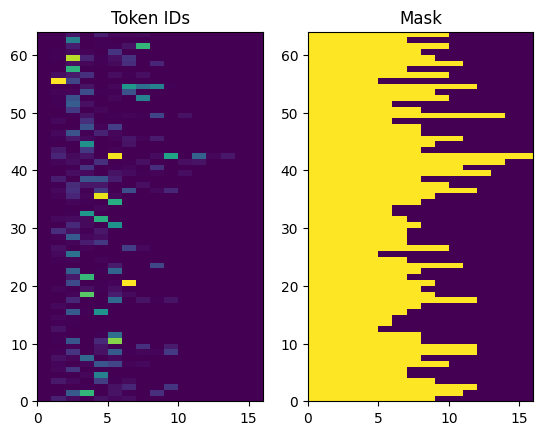

In [17]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

### process the dataset

in the following function, (context, target) becomes ((context,target_in), target_out) for training
keras expects (inputs, label) where here, (context, target_in) is the input, and target_out is the label
the difference between _in and _out is that _out is shifted one character right, so at each location, the label is the next token (expected value)

In [18]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out

train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [19]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy())

[   2   13   60  558 3882   14  485   12    3    0]

[   2  135  535   21  605 3700   11    0    0    0]
[ 135  535   21  605 3700   11    3    0    0    0]


## Step 2 - The encoder / decoder architecture and model

two simplifications from the original attention-based translation model - typically unnecessary:
- feeding state from encoder's RNN to the decoder's RNN
- Feeding attention output back to the RNN input 


In [20]:
UNITS = 256

### The encoder design

since context sequence is constant, information can flow between any units in the encoder, so use a bidirectional RNN

1. gets a list of token IDs
2. looks up an embedding vector for each token
3. processes the embeddings into a new sequence (using a bidirectional RNN
4. returns the processed sequence -> attention head

In [21]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [22]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 14)
Encoder output, shape (batch, s, units): (64, 14, 256)


### the attention layer

weighted average across comtext sequence - weights are a combination of context and "query" vectors

In [23]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()

    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)

    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')

    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [24]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 14, 256)
Target sequence, shape (batch, t, units): (64, 14, 256)
Attention result, shape (batch, t, units): (64, 14, 256)
Attention weights, shape (batch, t, s):    (64, 14, 14)


In [25]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.        , 1.0000001 , 1.        , 0.99999994, 1.        ,
       0.99999994, 0.99999994, 1.0000001 , 1.0000001 , 1.0000001 ,
       1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 ], dtype=float32)

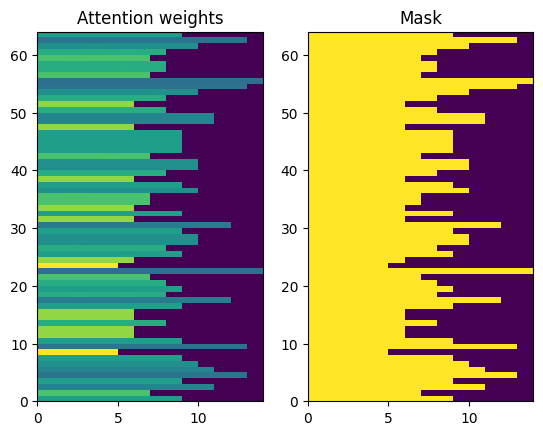

In [26]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');

### the decoder

1. looks up embeddings for each token in the target sequence
2. uses an RNN to process target sequence, and to track generated state
3. uses RNN output as the "query" to the attention layer, attending to encoder's output
4. At each location it predicts the next token - unidirectional RNN to process target sequence

In [27]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [28]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

In [29]:
decoder = Decoder(target_text_processor, UNITS)

In [30]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 14, 256)
input target tokens shape: (batch, t) (64, 14)
logits shape shape: (batch, target_vocabulary_size) (64, 14, 5000)


In [31]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [32]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [33]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 

  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

  return next_token, done, state

In [34]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'nuts approved sheep intervened adequate luxury teenager unbelievably former mountains',
       b'pick class reluctantly anybodys leaped math monday ahead fortunate divorce',
       b'task whatever stress awful resemble trips boiled opinions knock bent'],
      dtype=object)

## The complete model


In [35]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [36]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 14)
Target tokens, shape: (batch, t) (64, 14)
logits, shape: (batch, t, target_vocabulary_size) (64, 14, 5000)


In [37]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [38]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [39]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

In [40]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 8.517193, 'expected_acc': 0.0002}

In [41]:
model.evaluate(val_ds, steps=20, return_dict=True)


20/20 [==============================] - 8s 83ms/step - loss: 8.5247 - masked_acc: 6.5955e-04 - masked_loss: 8.5247


{'loss': 8.524713516235352,
 'masked_acc': 0.0006595536251552403,
 'masked_loss': 8.524713516235352}

In [42]:
history = model.fit(
    train_ds.repeat(), 
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100
100/100 [==============================] - 36s 258ms/step - loss: 5.0846 - masked_acc: 0.2514 - masked_loss: 5.0846 - val_loss: 4.1214 - val_masked_acc: 0.3502 - val_masked_loss: 4.1214
Epoch 2/100
100/100 [==============================] - 24s 241ms/step - loss: 3.7735 - masked_acc: 0.3958 - masked_loss: 3.7735 - val_loss: 3.3324 - val_masked_acc: 0.4514 - val_masked_loss: 3.3324
Epoch 3/100
100/100 [==============================] - 24s 240ms/step - loss: 3.1466 - masked_acc: 0.4757 - masked_loss: 3.1466 - val_loss: 2.9248 - val_masked_acc: 0.5013 - val_masked_loss: 2.9248
Epoch 4/100
100/100 [==============================] - 26s 263ms/step - loss: 2.7122 - masked_acc: 0.5380 - masked_loss: 2.7122 - val_loss: 2.4403 - val_masked_acc: 0.5733 - val_masked_loss: 2.4403
Epoch 5/100
100/100 [==============================] - 24s 241ms/step - loss: 2.3900 - masked_acc: 0.5856 - masked_loss: 2.3900 - val_loss: 2.2226 - val_masked_acc: 0.6033 - val_masked_loss: 2.2226
Epoch 6/10

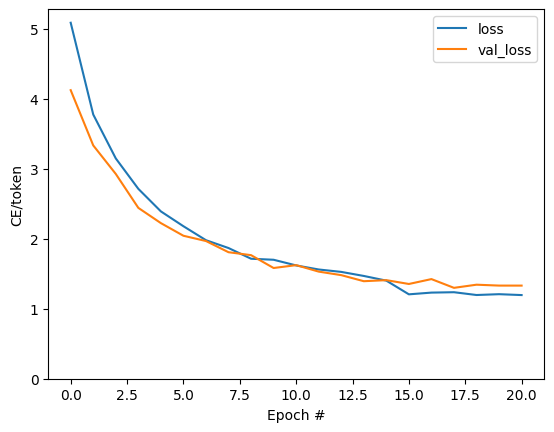

In [43]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

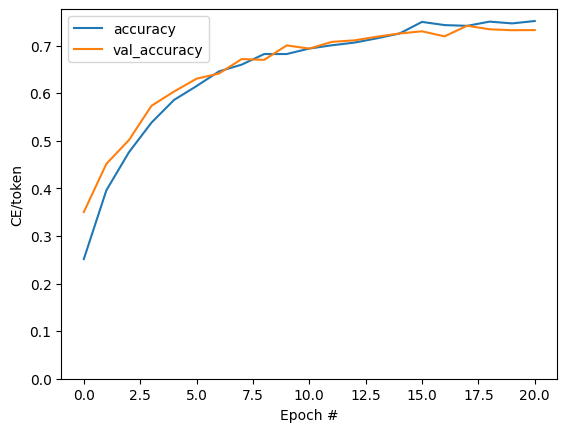

In [44]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [66]:
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)

    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [67]:
result = model.translate(['¿Todavía está en casa?']) # Are you still home
result[0].numpy().decode()

'is still at home ? '

In [68]:
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')

C:\Users\john\AppData\Local\Temp\ipykernel_34808\2375050876.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
C:\Users\john\AppData\Local\Temp\ipykernel_34808\2375050876.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output, fontdict=fontdict)


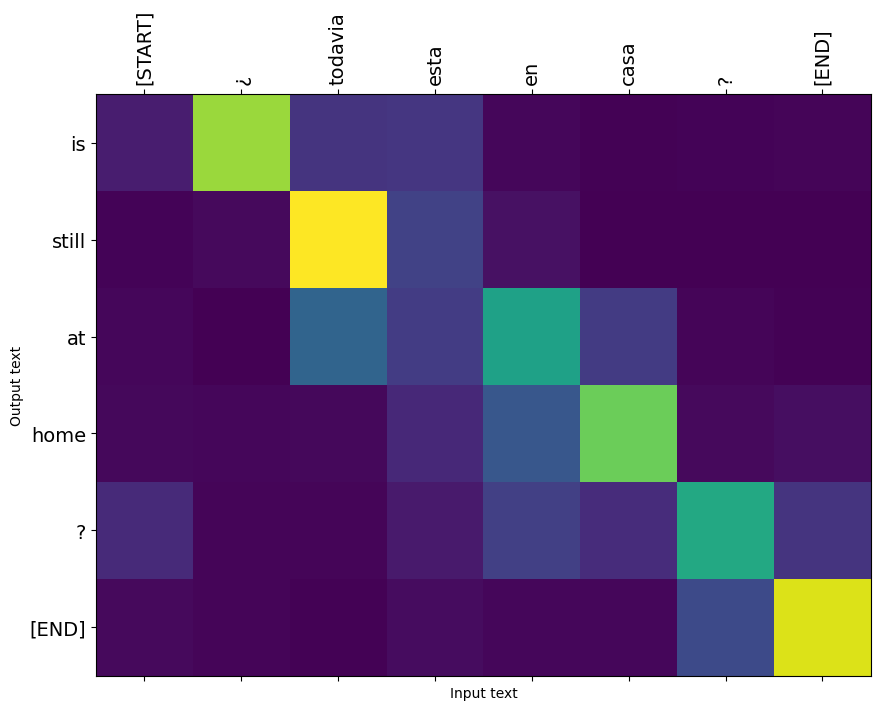

In [69]:
model.plot_attention('¿Todavía está en casa?') # Are you still home

C:\Users\john\AppData\Local\Temp\ipykernel_34808\2375050876.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
C:\Users\john\AppData\Local\Temp\ipykernel_34808\2375050876.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output, fontdict=fontdict)


CPU times: total: 46.9 ms
Wall time: 243 ms


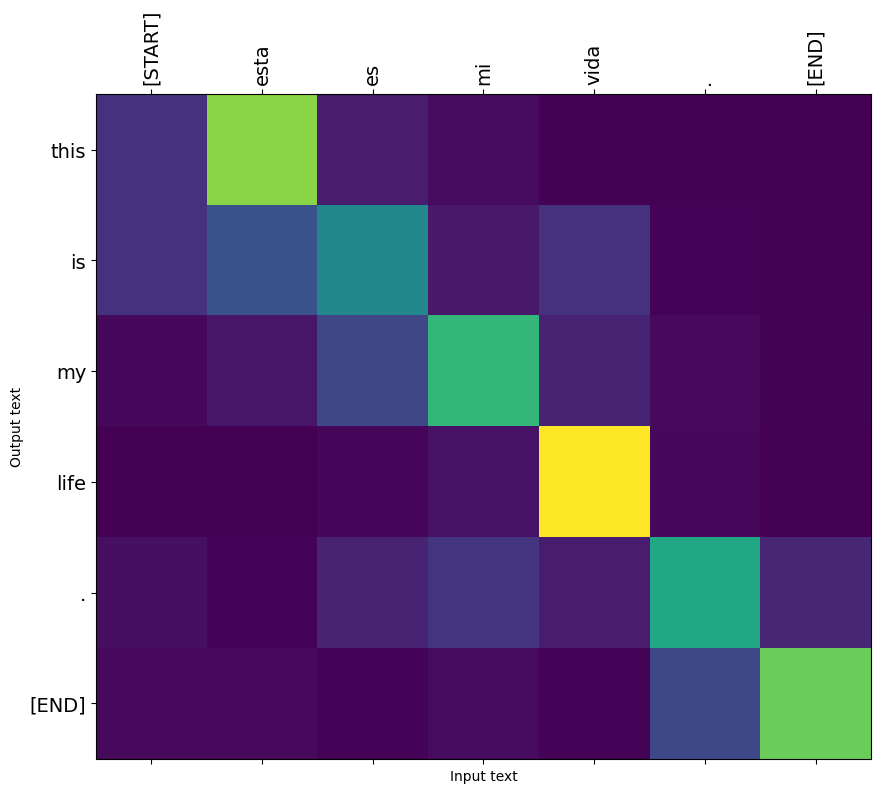

In [70]:
%%time
# This is my life.
model.plot_attention('Esta es mi vida.')

C:\Users\john\AppData\Local\Temp\ipykernel_34808\2375050876.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
C:\Users\john\AppData\Local\Temp\ipykernel_34808\2375050876.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output, fontdict=fontdict)


CPU times: total: 62.5 ms
Wall time: 226 ms


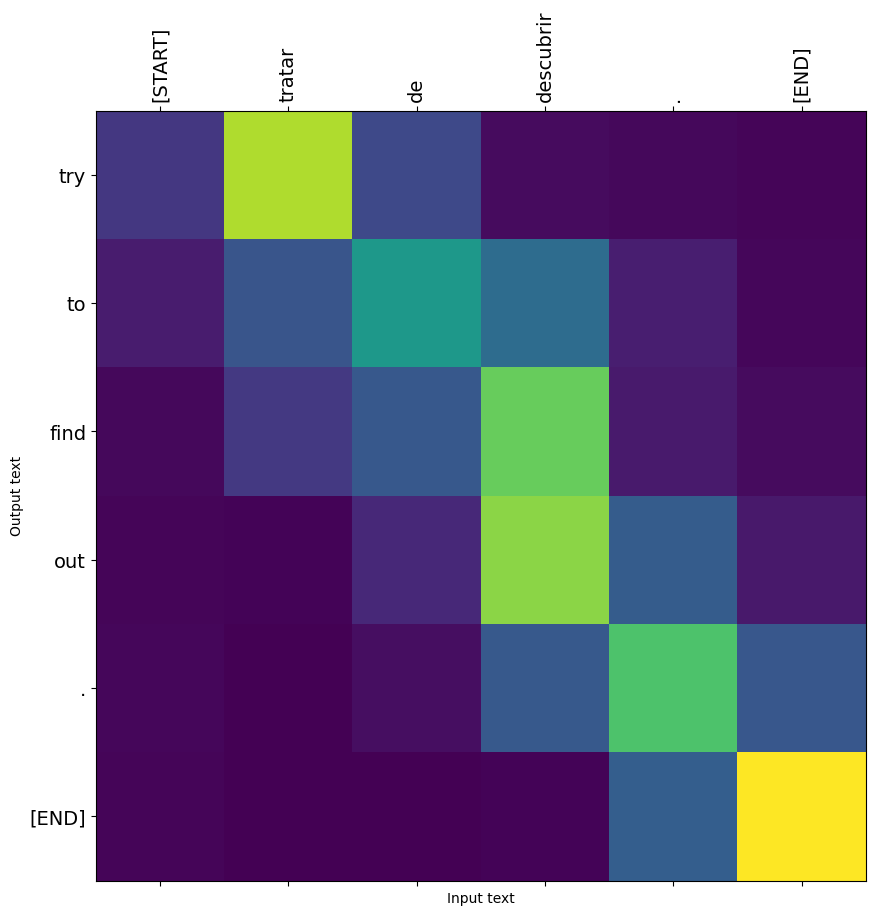

In [71]:
%%time
 # Try to find out.'
model.plot_attention('Tratar de descubrir.')

In [72]:
long_text = context_raw[-1]

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(target_raw[-1])))

Expected output:
 If you want to sound like a native speaker, you must be willing to
practice saying the same sentence over and over in the same way that
banjo players practice the same phrase over and over until they can
play it correctly and at the desired tempo.


C:\Users\john\AppData\Local\Temp\ipykernel_34808\2375050876.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
C:\Users\john\AppData\Local\Temp\ipykernel_34808\2375050876.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output, fontdict=fontdict)


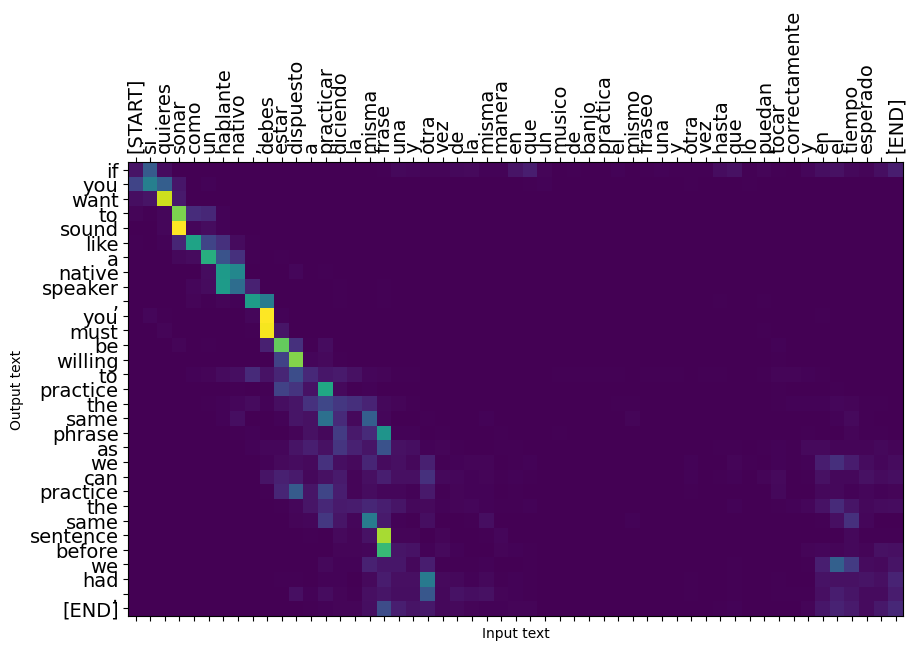

In [73]:
model.plot_attention(long_text)

In [74]:
inputs = [
    'Hace mucho frio aqui.', # "It's really cold here."
    'Esta es mi vida.', # "This is my life."
    'Su cuarto es un desastre.' # "His room is a mess"
]

In [75]:
%%time
for t in inputs:
  print(model.translate([t])[0].numpy().decode())

print()

its been very cold here . 
this is my life . 
his room is a disaster . 

CPU times: total: 266 ms
Wall time: 692 ms


In [76]:
%%time
result = model.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its been very cold here . 
this is my life .  
his room is a disaster . 

CPU times: total: 31.2 ms
Wall time: 276 ms


In [77]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

In [78]:
export = Export(model)

In [79]:
%%time
_ = export.translate(tf.constant(inputs))

CPU times: total: 24.4 s
Wall time: 56.6 s


In [80]:
%%time
result = export.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its been very cold here .                                            
this is my life .                                             
his room is a disaster .                                            

CPU times: total: 15.6 ms
Wall time: 157 ms


In [84]:
local_model_path = local_data_path_root+ "/models/"

In [85]:
%%time
tf.saved_model.save(export, local_model_path+'translator',
                    signatures={'serving_default': export.translate})

INFO:tensorflow:Assets written to: C:/LocalResearch/JPD-Research/translationWork/models/translator\assets


INFO:tensorflow:Assets written to: C:/LocalResearch/JPD-Research/translationWork/models/translator\assets


CPU times: total: 16.1 s
Wall time: 43.3 s


In [86]:
%%time
reloaded = tf.saved_model.load(local_model_path+'translator')
_ = reloaded.translate(tf.constant(inputs)) #warmup

CPU times: total: 25 s
Wall time: 1min 10s


In [87]:
%%time
result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its been very cold here .                                            
this is my life .                                             
his room is a disaster .                                            

CPU times: total: 0 ns
Wall time: 215 ms


In [88]:
@Translator.add_method
def translate(self,
              texts,
              *,
              max_length=500,
              temperature=tf.constant(0.0)):
  shape_checker = ShapeChecker()
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(context)[0]
  shape_checker(context, 'batch s units')

  next_token, done, state = self.decoder.get_initial_state(context)

  # initialize the accumulator
  tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)

  for t in tf.range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done, state, temperature)
    shape_checker(next_token, 'batch t1')

    # Collect the generated tokens
    tokens = tokens.write(t, next_token)

    # if all the sequences are done, break
    if tf.reduce_all(done):
      break

  # Convert the list of generated token ids to a list of strings.
  tokens = tokens.stack()
  shape_checker(tokens, 't batch t1')
  tokens = einops.rearrange(tokens, 't batch 1 -> batch t')
  shape_checker(tokens, 'batch t')

  text = self.decoder.tokens_to_text(tokens)
  shape_checker(text, 'batch')

  return text

In [89]:
%%time
result = model.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its been very cold here . 
this is my life .  
his room is a disaster . 

CPU times: total: 46.9 ms
Wall time: 394 ms


In [90]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

In [91]:
export = Export(model)

In [92]:
%%time
_ = export.translate(inputs)

CPU times: total: 1.08 s
Wall time: 3.74 s


In [93]:
%%time
result = export.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its been very cold here . 
this is my life .  
his room is a disaster . 

CPU times: total: 15.6 ms
Wall time: 54 ms


In [94]:
%%time
tf.saved_model.save(export, local_model_path+'dynamic_translator',
                    signatures={'serving_default': export.translate})

INFO:tensorflow:Assets written to: C:/LocalResearch/JPD-Research/translationWork/models/dynamic_translator\assets


INFO:tensorflow:Assets written to: C:/LocalResearch/JPD-Research/translationWork/models/dynamic_translator\assets


CPU times: total: 14 s
Wall time: 31.9 s


In [97]:
%%time
reloaded = tf.saved_model.load(local_model_path+'dynamic_translator')
_ = reloaded.translate(tf.constant(inputs)) #warmup

CPU times: total: 7.55 s
Wall time: 24.7 s


In [98]:
%%time
result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its been very cold here . 
this is my life .  
his room is a disaster . 

CPU times: total: 46.9 ms
Wall time: 93.5 ms


## Step n - Still to do
- 
better understand    - 
thattention model here as opposed to the transformer versione    - r
Working with RN- , no?
enable GPU (local and on Rosie)